In [1]:
from sklearn.model_selection import train_test_split
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import requests
import plotly.graph_objects as go
import numpy as np
import shap
import joblib

/home/arianewsl/ocp7/envapi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Version SHAP :", shap.__version__)
# print("Version st_pages :", st_pages.__version__)

Version SHAP : 0.47.2


In [3]:
from src.modeling.p7_constantes import MODEL_DIR, DATA_CLEAN_DIR
import warnings

In [4]:
warnings.filterwarnings("ignore")

# Comment les shap values sont calculées sur un exemple simple

In [5]:
"""
Les SHAP values (SHapley Additive exPlanations) disent pour chaque prédiction (chaque ligne)
combien chaque feature contribue à la prédiction du modèle, par rapport à la moyenne.

"""

'\nLes SHAP values (SHapley Additive exPlanations) disent pour chaque prédiction (chaque ligne)\ncombien chaque feature contribue à la prédiction du modèle, par rapport à la moyenne.\n\n'

Principe issu de la théorie des jeux (et ordonnancement)

In [6]:
"""
Les SHAP values viennent de la théorie des jeux coopératifs.
On imagine un jeu ou plusieurs joeurs (les features) s'associent pour produire un gain (la prédicition du modèle)
On veut répartir ce gain entre chaque joueur en fonction de leur contribution individuelle.
Tous les joueurs n'arrivent pas tous en même temps.
Leur contribution ne sera pas la même selon leur ordre d'arrivée dans le jeu.
(On ne peut évaluer la contribution d'un joueur spécifique que connaisant la contribution des autres)
Nous devons donc envisager tous les cas possibles d'ordre d'arrivée des joueurs.
"""

"\nLes SHAP values viennent de la théorie des jeux coopératifs.\nOn imagine un jeu ou plusieurs joeurs (les features) s'associent pour produire un gain (la prédicition du modèle)\nOn veut répartir ce gain entre chaque joueur en fonction de leur contribution individuelle.\nTous les joueurs n'arrivent pas tous en même temps.\nLeur contribution ne sera pas la même selon leur ordre d'arrivée dans le jeu.\n(On ne peut évaluer la contribution d'un joueur spécifique que connaisant la contribution des autres)\nNous devons donc envisager tous les cas possibles d'ordre d'arrivée des joueurs.\n"

modèle à 3 features

In [7]:
"""
Imaginons un modèle avec 3 features seulement :
x1 = âge
x2 = revenu
x3 = statut_marital
Le modèle retourne une probabilité de faire défaut.
"""

'\nImaginons un modèle avec 3 features seulement :\nx1 = âge\nx2 = revenu\nx3 = statut_marital\nLe modèle retourne une probabilité de faire défaut.\n'

prédictions selon les combinaisons possibles de features

In [8]:
"""
il y a 8 (2 puissance 3) combinaisons possibles.
Imaginons les sorties du modèle suivantes:

∅ (aucune feature)	0.4 (Si dans la base, il y a 40% de de gens qui font défaut alors sans aucune feature la probabilité de faire défaut est de 0.4)
x1	                0.5
x2	                0.6
x3	                0.55
x1, x2	            0.7
x1, x3	            0.65
x2, x3	            0.72
x1, x2, x3	        0.8
"""

'\nil y a 8 (2 puissance 3) combinaisons possibles.\nImaginons les sorties du modèle suivantes:\n\n∅ (aucune feature)\t0.4 (Si dans la base, il y a 40% de de gens qui font défaut alors sans aucune feature la probabilité de faire défaut est de 0.4)\nx1\t                0.5\nx2\t                0.6\nx3\t                0.55\nx1, x2\t            0.7\nx1, x3\t            0.65\nx2, x3\t            0.72\nx1, x2, x3\t        0.8\n'

Calcul de la Base value (ou valeur de référence) et différence à expliquer

In [9]:
"""
La base value est la valeur moyenne des prédictions sur tous les sous-ensembles de features
pour SHAP, cette valeur est notée E[f(X)]

base_value = (0.4 + 0.5 + 0.6 + 0.55 + 0.7 + 0.65 + 0.72 + 0.8) / 8
           = 4.92 / 8
           = 0.615


"""

'\nLa base value est la valeur moyenne des prédictions sur tous les sous-ensembles de features\npour SHAP, cette valeur est notée E[f(X)]\n\nbase_value = (0.4 + 0.5 + 0.6 + 0.55 + 0.7 + 0.65 + 0.72 + 0.8) / 8\n           = 4.92 / 8\n           = 0.615\n\n\n'

Calcul des shap values

In [10]:
"""
Notre modèle avec toutes ses features (x1, x2, x3) prédit 0.8,
La contribution des 3 features prises ensemble est
La différence à expliquer par rapport à la moyenne 0.8 - 0.615 = +0.185

Calculer les shap values revient à calculer la contribution de chaque feature à ces +0.185

Par exemple pour la feature x1 :
On calcule sa contribution marginale dans chaque ordre possible, puis on fait la moyenne
Avec 3 features, il y a 3! (3*2*1 = 6) possibilités

Tous les ordres où x1 apparaît :
x1, x2, x3
    contribution : f({x1}) - f(∅) = 0.5 - 0.4 = 0.1
x2, x1, x3
    contribution : f({x1,x2}) - f({x2}) = 0.7 - 0.6 = 0.1
x2, x3, x1
    contribution : f({x1,x2,x3}) - f({x2,x3}) = 0.8 - 0.72 = 0.08
x3, x1, x2
    contribution : f({x1,x3}) - f({x3}) = 0.65 - 0.55 = 0.10
x3, x2, x1
    contribution : f({x1,x2,x3}) - f({x2,x3}) = 0.8 - 0.72 = 0.08
x1, x3, x2
    contribution : f({x1}) - f(∅) = 0.5 - 0.4 = 0.1

SHAP(x1) = (0.1 + 0.1 + 0.08 + 0.10 + 0.08 + 0.1) / 6 = +0.0933

# On fait la même chose pour la autres features x2 et x3

Supposons qu'on obtienne :
SHAP(x2) =	+0.057
SHAP(x3) =	+0.035

Au total on a
SHAP(x1) + SHAP(x2) + SHAP(x3) = +0.185 (Notre différence à axpliquer par rapport à la moyenne)
f(x) = base_value + SHAP(x1) + SHAP(x2) + SHAP(x3)
     = 0.615     + 0.093     + 0.057     + 0.035
     = 0.800

"""

"\nNotre modèle avec toutes ses features (x1, x2, x3) prédit 0.8,\nLa contribution des 3 features prises ensemble est\nLa différence à expliquer par rapport à la moyenne 0.8 - 0.615 = +0.185\n\nCalculer les shap values revient à calculer la contribution de chaque feature à ces +0.185\n\nPar exemple pour la feature x1 :\nOn calcule sa contribution marginale dans chaque ordre possible, puis on fait la moyenne\nAvec 3 features, il y a 3! (3*2*1 = 6) possibilités\n\nTous les ordres où x1 apparaît :\nx1, x2, x3\n    contribution : f({x1}) - f(∅) = 0.5 - 0.4 = 0.1\nx2, x1, x3\n    contribution : f({x1,x2}) - f({x2}) = 0.7 - 0.6 = 0.1\nx2, x3, x1\n    contribution : f({x1,x2,x3}) - f({x2,x3}) = 0.8 - 0.72 = 0.08\nx3, x1, x2\n    contribution : f({x1,x3}) - f({x3}) = 0.65 - 0.55 = 0.10\nx3, x2, x1\n    contribution : f({x1,x2,x3}) - f({x2,x3}) = 0.8 - 0.72 = 0.08\nx1, x3, x2\n    contribution : f({x1}) - f(∅) = 0.5 - 0.4 = 0.1\n\nSHAP(x1) = (0.1 + 0.1 + 0.08 + 0.10 + 0.08 + 0.1) / 6 = +0.0933\

# Données

## Lecture du modèle

In [11]:
path_model = os.path.join(MODEL_DIR, "best_model_lgbm.pkl")
model = joblib.load(path_model)

## Lecture du train et des nouveaux emprunts

In [12]:
path_train = os.path.join(DATA_CLEAN_DIR, "train_lgbm.csv")
train = pd.read_csv(path_train)
if "SK_ID_CURR" in train.columns:
    train_indexed = train.set_index("SK_ID_CURR")
else:
    train_indexed = train


X_train = train_indexed.drop(columns=["TARGET"])
y_train = train_indexed["TARGET"]

path_new_loans = os.path.join(DATA_CLEAN_DIR, "X_new_loans_lgbm.csv")
X_new_loans = pd.read_csv(path_new_loans).set_index("SK_ID_CURR")

In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230634 entries, 127032 to 421871
Data columns (total 87 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   CODE_GENDER                            230634 non-null  int64  
 1   AMT_ANNUITY                            230626 non-null  float64
 2   REGION_POPULATION_RELATIVE             230634 non-null  float64
 3   DAYS_BIRTH                             230634 non-null  int64  
 4   DAYS_EMPLOYED                          189075 non-null  float64
 5   DAYS_REGISTRATION                      230634 non-null  float64
 6   DAYS_ID_PUBLISH                        230634 non-null  int64  
 7   OWN_CAR_AGE                            78227 non-null   float64
 8   REGION_RATING_CLIENT_W_CITY            230634 non-null  int64  
 9   EXT_SOURCE_1                           100812 non-null  float64
 10  EXT_SOURCE_2                           230153 non-null  

In [14]:
X_new_loans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48744 entries, 258223 to 424220
Data columns (total 87 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   CODE_GENDER                            48744 non-null  bool   
 1   AMT_ANNUITY                            48720 non-null  float64
 2   REGION_POPULATION_RELATIVE             48744 non-null  float64
 3   DAYS_BIRTH                             48744 non-null  int64  
 4   DAYS_EMPLOYED                          39470 non-null  float64
 5   DAYS_REGISTRATION                      48744 non-null  float64
 6   DAYS_ID_PUBLISH                        48744 non-null  int64  
 7   OWN_CAR_AGE                            16432 non-null  float64
 8   REGION_RATING_CLIENT_W_CITY            48744 non-null  int64  
 9   EXT_SOURCE_1                           28212 non-null  float64
 10  EXT_SOURCE_2                           48736 non-null  float64
 11  E

## Pas de bool pour shap

In [15]:
bool_features = X_train.select_dtypes("bool").columns.to_list()
bool_features

['NAME_EDUCATION_TYPE_Highereducation', 'NAME_FAMILY_STATUS_Married']

In [16]:
X_train[bool_features] = X_train[bool_features].astype("int")
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230634 entries, 127032 to 421871
Data columns (total 87 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   CODE_GENDER                            230634 non-null  int64  
 1   AMT_ANNUITY                            230626 non-null  float64
 2   REGION_POPULATION_RELATIVE             230634 non-null  float64
 3   DAYS_BIRTH                             230634 non-null  int64  
 4   DAYS_EMPLOYED                          189075 non-null  float64
 5   DAYS_REGISTRATION                      230634 non-null  float64
 6   DAYS_ID_PUBLISH                        230634 non-null  int64  
 7   OWN_CAR_AGE                            78227 non-null   float64
 8   REGION_RATING_CLIENT_W_CITY            230634 non-null  int64  
 9   EXT_SOURCE_1                           100812 non-null  float64
 10  EXT_SOURCE_2                           230153 non-null  

## Caster new loans comme train

In [17]:
X_new_loans = X_new_loans.astype(X_train.dtypes.to_dict())
X_new_loans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48744 entries, 258223 to 424220
Data columns (total 87 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   CODE_GENDER                            48744 non-null  int64  
 1   AMT_ANNUITY                            48720 non-null  float64
 2   REGION_POPULATION_RELATIVE             48744 non-null  float64
 3   DAYS_BIRTH                             48744 non-null  int64  
 4   DAYS_EMPLOYED                          39470 non-null  float64
 5   DAYS_REGISTRATION                      48744 non-null  float64
 6   DAYS_ID_PUBLISH                        48744 non-null  int64  
 7   OWN_CAR_AGE                            16432 non-null  float64
 8   REGION_RATING_CLIENT_W_CITY            48744 non-null  int64  
 9   EXT_SOURCE_1                           28212 non-null  float64
 10  EXT_SOURCE_2                           48736 non-null  float64
 11  E

## Echantillon du train

In [62]:
# Un échantillon de 3% représente presque 7_000 lignes, ce sera suffisant
_, X_sampled_train, _, y_sampled_train = train_test_split(
    X_train, y_train, test_size=0.20, random_state=42, stratify=y_train
)
X_sampled_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46127 entries, 222182 to 187092
Data columns (total 87 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   CODE_GENDER                            46127 non-null  int64  
 1   AMT_ANNUITY                            46126 non-null  float64
 2   REGION_POPULATION_RELATIVE             46127 non-null  float64
 3   DAYS_BIRTH                             46127 non-null  int64  
 4   DAYS_EMPLOYED                          37788 non-null  float64
 5   DAYS_REGISTRATION                      46127 non-null  float64
 6   DAYS_ID_PUBLISH                        46127 non-null  int64  
 7   OWN_CAR_AGE                            15810 non-null  float64
 8   REGION_RATING_CLIENT_W_CITY            46127 non-null  int64  
 9   EXT_SOURCE_1                           20102 non-null  float64
 10  EXT_SOURCE_2                           46019 non-null  float64
 11  E

In [63]:
X_sampled_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46127 entries, 222182 to 187092
Data columns (total 87 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   CODE_GENDER                            46127 non-null  int64  
 1   AMT_ANNUITY                            46126 non-null  float64
 2   REGION_POPULATION_RELATIVE             46127 non-null  float64
 3   DAYS_BIRTH                             46127 non-null  int64  
 4   DAYS_EMPLOYED                          37788 non-null  float64
 5   DAYS_REGISTRATION                      46127 non-null  float64
 6   DAYS_ID_PUBLISH                        46127 non-null  int64  
 7   OWN_CAR_AGE                            15810 non-null  float64
 8   REGION_RATING_CLIENT_W_CITY            46127 non-null  int64  
 9   EXT_SOURCE_1                           20102 non-null  float64
 10  EXT_SOURCE_2                           46019 non-null  float64
 11  E

In [64]:
# Sauvegarde de l'échantillon
path_X = os.path.join(DATA_CLEAN_DIR, "X_sampled_train_lgbm.csv")
X_sampled_train.to_csv(path_X, index=True)
print(
    f"X (Echantillon du train sans target indexé par 'SK_ID_CURR') sauvegardé dans {path_X}"
)
print(
    f"Forme de X : {X_sampled_train.shape[0]} lignes, {X_sampled_train.shape[1]} features"
)
path_y = os.path.join(DATA_CLEAN_DIR, "y_sampled_train_lgbm.csv")
y_sampled_train.to_csv(path_y, index=True)
print(
    f"\ny (Target de l'échantillon du train indexée par 'SK_ID_CURR') sauvegardé dans {path_y}"
)
print(f"Nombre de lignes de y :", len(y_sampled_train))

X (Echantillon du train sans target indexé par 'SK_ID_CURR') sauvegardé dans data/cleaned/X_sampled_train_lgbm.csv
Forme de X : 46127 lignes, 87 features

y (Target de l'échantillon du train indexée par 'SK_ID_CURR') sauvegardé dans data/cleaned/y_sampled_train_lgbm.csv
Nombre de lignes de y : 46127


In [65]:
# On sauvegarde aussi le dtype des données
dic_dtypes = X_train.dtypes.to_dict()
path_dtypes = os.path.join(DATA_CLEAN_DIR, "dtypes_lgbm.pkl")
joblib.dump(dic_dtypes, path_dtypes)
print(f"Dtypes en registré dans {path_dtypes}")
print("Nombre de clefs :", len(dic_dtypes.keys()))

Dtypes en registré dans data/cleaned/dtypes_lgbm.pkl
Nombre de clefs : 87


In [66]:
def plot_default_ratio(series):
    labels = ["Remb. Ok", "Défaut"]
    # Plot en camembert
    fig, ax = plt.subplots(figsize=(7, 5))
    fig.suptitle(
        f"Pourcentage de prêts avec et sans défaut de remboursement\nNombre d'observations : {len(series):_}",
        ha="left",  # Aligne les deux ligne du titre sur leur gauche
        x=0.0,  # Positionne les lignes du titres complètement à gauche
    )
    ratio = series.value_counts(normalize=True)
    # Si on a un cudf la conversion en numpy est nécessaire. Si on a un pd.df, la conversion ne nuit pas.
    ax.pie(
        series.value_counts(normalize=True).to_numpy(),
        labels=labels,
        autopct="%.1f%%",
    )

    fig.legend(loc="lower right")
    fig.tight_layout()
    return fig

In [67]:
_ = plot_default_ratio(y_train)

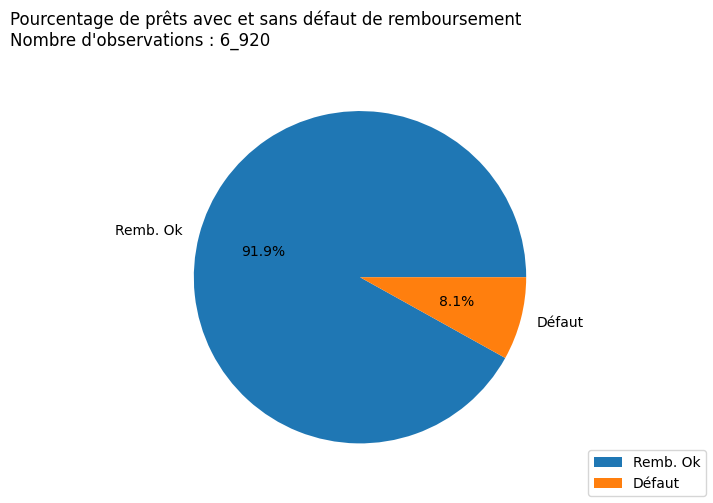

In [24]:
_ = plot_default_ratio(y_sampled_train)

# Contribution des features au risque de défaut (SHAP Explanation)

## Calcul des éléments SHAP

### Explainer

In [25]:
# Le modèle doit être fitté sur l'ensemble du Train
model.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', colsample_bytree=0.8129221232621212,
               force_col_wise=True, learning_rate=0.016300066315934513,
               min_child_samples=62, min_split_gain=0.7870491861754971,
               n_estimators=800, n_jobs=14, num_leaves=244, objective='binary',
               random_state=42, subsample=0.7553729073561358, verbosity=-1)

In [26]:
# On sauvegarde le modèle fitté
path_model = os.path.join(MODEL_DIR, "best_model_lgbm.pkl")
joblib.dump(model, path_model)

['models/best_model_lgbm.pkl']

In [ ]:
from numpy import mean


proba = model.predict_proba(X_train)[:, 1]

[LightGBM] [Fatal] The number of features in data (88) is not the same as it was in training data (87).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.


LightGBMError: The number of features in data (88) is not the same as it was in training data (87).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

In [ ]:
X_train["PROBA"] = proba
X_train.groupby("CODE_GENDER").aggregate(mean)

,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1,EXT_SOURCE_2,...,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_SUM,CC_AMT_BALANCE_MEAN,CC_AMT_PAYMENT_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_VAR,PROBA
CODE_GENDER,,,,,,,,,,,,,,,,,,,,,
-1,17625.000000,0.027632,-14865.333333,-4689.666667,-4149.333333,-3289.000000,13.000000,2.333333,0.404970,0.554796,...,422804.046900,2850.734950,-49.666667,-40952.333333,NaN,NaN,NaN,NaN,NaN,0.323406
0,28643.335978,0.021124,-15150.595705,-2102.243852,-4611.593937,-2996.798698,11.941632,2.019671,0.407460,0.510430,...,623836.572193,5305.115381,-346.182894,-39174.056054,73228.192020,461934.28084,0.594458,1.788407,19.095952,0.309573
1,26309.531250,0.020713,-16500.409295,-2559.068992,-5185.084290,-2995.339639,12.084248,2.039161,0.546279,0.516343,...,695080.518045,5151.955930,-318.841201,-42926.667846,70635.757335,422838.98093,0.549244,1.414221,12.952582,0.239714


In [ ]:
# Par soucis de temps de calcul et d'économie de RAM, nous travaillons sur un échantillon du Train

In [68]:
# Créer l'explainer avec un contexte
explainer = shap.TreeExplainer(
    model=model,
    data=X_sampled_train,
    model_output="probability",
    feature_names=X_sampled_train.columns.to_list(),
)

# On affiche la valeur de référence. Si notre échantillon est bien représentatif de la population,
# alors la valeur de référence doit être proche de celle que l'on aurait en s'appuyant sur la totalité du Train
base_value = explainer.expected_value
print(f"Valeur de base pour notre contexte échantillonné {base_value:.4f}")

Valeur de base pour notre contexte échantillonné 0.2481


In [69]:
# On sauvegarde l'explainer
path_explainer = os.path.join(MODEL_DIR, "explainer_lgbm.pkl")
joblib.dump(explainer, path_explainer)
print(f"Explainer sauvegardé dans {path_explainer}")

Explainer sauvegardé dans models/explainer_lgbm.pkl


### Valeurs SHAP pour l'échantillon de Train

In [70]:
shap_values = explainer(X_sampled_train)

100%|===================| 46118/46127 [71:19<00:00]        

In [71]:
shap_values

.values =
array([[-0.02698463,  0.02060631,  0.01062444, ..., -0.0054599 ,
         0.00269165,  0.001891  ],
       [-0.01229574,  0.03318694,  0.01002681, ..., -0.00428806,
        -0.00402754, -0.00513352],
       [-0.02316572,  0.00711939,  0.00693468, ..., -0.00577352,
         0.00050152, -0.00044036],
       ...,
       [-0.00704808, -0.02259628, -0.00276492, ...,  0.01177469,
         0.00928365,  0.02349495],
       [ 0.01272684,  0.02071844,  0.00676627, ..., -0.00298296,
        -0.00013873,  0.00040321],
       [-0.01854187, -0.04116633,  0.00299821, ...,  0.03667228,
        -0.005284  , -0.00665415]])

.base_values =
array([0.2480556, 0.2480556, 0.2480556, ..., 0.2480556, 0.2480556,
       0.2480556])

.data =
array([[1.00000000e+00, 2.85210000e+04, 3.07550000e-02, ...,
                   nan,            nan,            nan],
       [1.00000000e+00, 3.53925000e+04, 1.96889990e-02, ...,
        8.64197540e-02, 8.53658540e-02, 1.77807882e-01],
       [1.00000000e+00, 2.4376

In [72]:
# On sauvegarde ces shap_values (sous forme d'objet)
# Sauvegarde de l'explainer
path_values = os.path.join(MODEL_DIR, "shap_values_lgbm.pkl")
joblib.dump(shap_values, path_values)
print(f"SHAP values de l'échantillon de train sauvegardées dans {path_values}")

SHAP values de l'échantillon de train sauvegardées dans models/shap_values_lgbm.pkl


In [73]:
# Visualisation des valeurs shap sous forme de DataFrame
df_shap_values = pd.DataFrame(
    shap_values.values,
    index=X_sampled_train.index,
    columns=X_sampled_train.columns,
)

In [74]:
df_shap_values.head()

,CODE_GENDER,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_SUM,CC_AMT_BALANCE_MEAN,CC_AMT_PAYMENT_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_VAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
222182,-0.026985,0.020606,0.010624,0.026167,0.013179,-0.002058,-0.015525,0.011468,-0.000597,0.022979,...,-0.000636,-0.007664,0.009712,-0.013702,-0.006989,-0.000328,0.000412,-0.005460,0.002692,0.001891
269035,-0.012296,0.033187,0.010027,0.007652,-0.070864,0.000084,0.004090,0.010375,0.001734,-0.074667,...,0.009670,-0.002225,0.003332,-0.002951,-0.013611,0.000890,0.003748,-0.004288,-0.004028,-0.005134
115155,-0.023166,0.007119,0.006935,-0.016307,0.012885,0.003527,0.004318,-0.014088,0.003473,0.015830,...,0.012796,0.010108,0.005099,0.015922,-0.010503,0.000698,0.001378,-0.005774,0.000502,-0.000440
391601,-0.007612,-0.009742,0.009018,0.019125,0.000302,0.007402,0.006686,0.011502,0.004758,-0.091500,...,0.008849,0.008146,0.005346,0.008253,0.004513,0.000564,0.000967,-0.005404,0.001011,0.002496
249522,-0.009048,0.002090,-0.010058,-0.019267,-0.020233,-0.012577,-0.005389,0.003202,-0.013770,0.001149,...,-0.005399,-0.012337,0.000184,-0.007880,-0.005788,-0.000210,0.000302,-0.003701,-0.000109,0.000475


In [75]:
# Sauvegarde des Valeurs SHAP sous forme de df
path_df_values = os.path.join(MODEL_DIR, "df_shap_values_lgbm.csv")
df_shap_values.to_csv(path_df_values, index=True)
print(
    f"DataFrame des valeurs SHAP indexé par 'SK_ID_CURR' sauvegardé dans {path_df_values}"
)
print(
    f"Forme du DataFrame : {df_shap_values.shape[0]} lignes, {df_shap_values.shape[1]} features"
)

DataFrame des valeurs SHAP indexé par 'SK_ID_CURR' sauvegardé dans models/df_shap_values_lgbm.csv
Forme du DataFrame : 46127 lignes, 87 features


### Valeur de base (Expected/Base Value)

In [76]:
print("Valeur de base (Expected/Base Value)  : ", explainer.expected_value)

Valeur de base (Expected/Base Value)  :  0.2480555997589449


### Shap values d'un nouvel emprunteur

In [77]:
X_new_loans.head(2)

,CODE_GENDER,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_SUM,CC_AMT_BALANCE_MEAN,CC_AMT_PAYMENT_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_VAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
258223,0,22117.5,0.022625,-19708,-154.0,-4102.0,-3141,NaN,2,NaN,...,20127.918,1268058.8,7.605,-37.0,-38820.0,95575.39,214705.67,0.615385,0.432432,1.030030
258231,0,23305.5,0.011703,-9787,-1501.0,-145.0,-1098,8.0,2,0.350171,...,9652.723,752912.4,0.765,-217.0,-59586.0,50868.95,182925.00,0.000000,3.941176,42.683823


In [78]:
loan_idx = 258223
X_new_loans.loc[[loan_idx], :]

,CODE_GENDER,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_SUM,CC_AMT_BALANCE_MEAN,CC_AMT_PAYMENT_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_VAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
258223,0,22117.5,0.022625,-19708,-154.0,-4102.0,-3141,NaN,2,NaN,...,20127.918,1268058.8,7.605,-37.0,-38820.0,95575.39,214705.67,0.615385,0.432432,1.03003


In [79]:
shap_values_loan = explainer(X_new_loans.loc[[loan_idx], :])
print(f"Shap Values du nouvel emprunteur ID {loan_idx} : ")
shap_values_loan.values[0]
df_shap_values_loaner = pd.Series(shap_values_loan.values[0], index=X_new_loans.columns)
df_shap_values_loaner

Shap Values du nouvel emprunteur ID 258223 : 


CODE_GENDER                         0.033512
AMT_ANNUITY                        -0.003575
REGION_POPULATION_RELATIVE          0.008051
DAYS_BIRTH                          0.002438
DAYS_EMPLOYED                       0.021737
                                      ...   
CC_AMT_BALANCE_MEAN                 0.019976
CC_AMT_PAYMENT_CURRENT_SUM          0.004962
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN    0.027337
CC_CNT_DRAWINGS_CURRENT_MEAN        0.001553
CC_CNT_DRAWINGS_CURRENT_VAR        -0.001672
Length: 87, dtype: float64

## Comparaison du risque de défaut calculé par le modèle et calculé par SHAP

In [80]:
prediction = model.predict_proba(X_new_loans.loc[[loan_idx], :])[0][1]
print("Risque de défaut calculé par le modèle :")
print(prediction)
print("Risque de défaut calculé en additionnant les valeurs SHAP à la valeur de base :")
print(explainer.expected_value + shap_values_loan.values.sum())

Risque de défaut calculé par le modèle :
0.27955843839029554
Risque de défaut calculé en additionnant les valeurs SHAP à la valeur de base :
0.27954805001198696


In [ ]:
"""
Les deux valeurs sont extrêment proches, ce qui montre que notre explainer reflète bien notre modèle.
L'échantillon représentatif du Train est donc suffisant.
"""

## Sauvegarde

In [ ]:
# Sauvegarde des shap_values

## Global Explanation : Contribution moyenne des features au risque de défaut

In [ ]:
"""
L'explication globale du modèle s'effectue avec les moyennes des valeurs SHAP de notre échantillon du modèle.
Elle reflète l'importance ou la contribution de chaque feature dnas la sortie de notre modèle qui est le calcul du risque de faire défaut.

Pour un emprunteur (une ligne des valeurs SHAP), et une feature (une colonne des valeurs SHAP),
la valeur est négative si la feature contribue à baisser le risque et
la valeur est positive si la feature contribue à augmenter le risque de défaut.

Indépendemment du signe, Plus la valeur SHAP est en VALEUR ABSOLUE importante,
plus la contribution de la feature est forte dans le calcul du risque.

Pour savoir si une feature est globalement importante (en moyenne sur les individus du Train),
il faut donc faire la moyenne des valeurs absolues des valeurs SHAP.
"""

In [81]:
df_shap_values.head()

,CODE_GENDER,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_SUM,CC_AMT_BALANCE_MEAN,CC_AMT_PAYMENT_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_VAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
222182,-0.026985,0.020606,0.010624,0.026167,0.013179,-0.002058,-0.015525,0.011468,-0.000597,0.022979,...,-0.000636,-0.007664,0.009712,-0.013702,-0.006989,-0.000328,0.000412,-0.005460,0.002692,0.001891
269035,-0.012296,0.033187,0.010027,0.007652,-0.070864,0.000084,0.004090,0.010375,0.001734,-0.074667,...,0.009670,-0.002225,0.003332,-0.002951,-0.013611,0.000890,0.003748,-0.004288,-0.004028,-0.005134
115155,-0.023166,0.007119,0.006935,-0.016307,0.012885,0.003527,0.004318,-0.014088,0.003473,0.015830,...,0.012796,0.010108,0.005099,0.015922,-0.010503,0.000698,0.001378,-0.005774,0.000502,-0.000440
391601,-0.007612,-0.009742,0.009018,0.019125,0.000302,0.007402,0.006686,0.011502,0.004758,-0.091500,...,0.008849,0.008146,0.005346,0.008253,0.004513,0.000564,0.000967,-0.005404,0.001011,0.002496
249522,-0.009048,0.002090,-0.010058,-0.019267,-0.020233,-0.012577,-0.005389,0.003202,-0.013770,0.001149,...,-0.005399,-0.012337,0.000184,-0.007880,-0.005788,-0.000210,0.000302,-0.003701,-0.000109,0.000475


In [82]:
df_global_importance = (
    df_shap_values.abs()
    .mean()
    .sort_values(ascending=False)
    .reset_index(name="importance_abs")
)
df_global_importance = df_global_importance.rename(columns={"index": "feature"})
df_global_importance

,feature,importance_abs
0,EXT_SOURCE_2,0.051718
1,EXT_SOURCE_3,0.045321
2,EXT_SOURCE_1,0.026095
3,CREDIT_TO_ANNUITY_RATIO,0.024044
4,AMT_ANNUITY,0.018768
...,...,...
82,CC_CNT_DRAWINGS_CURRENT_MEAN,0.002225
83,PREV_DAYS_DECISION_MAX,0.002077
84,APPROVED_AMT_GOODS_PRICE_MAX,0.002049
85,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,0.001977


### Bar plot

In [83]:
# Moyenne absolue des SHAP values pour chaque variable
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
feature_names = X_sampled_train.columns

# On trie par importance décroissante
sorted_idx = np.argsort(mean_abs_shap)[::-1]
sorted_features = feature_names[sorted_idx]
sorted_importances = mean_abs_shap[sorted_idx]


# Top N à afficher
top_n = 20
plot_others = False
top_features = sorted_features[:top_n]
top_importances = sorted_importances[:top_n]

# Somme des autres importances (les importances sont additives)
other_importance = sorted_importances[top_n:].sum()

# Ajout de la barre "Reste"
top_features_extended = np.append(top_features, "Autres features")
top_importances_extended = np.append(top_importances, other_importance)

# Plot
if plot_others:
    height = (top_n + 1) * 0.3
else:
    height = (top_n) * 0.3
fig, ax = plt.subplots(figsize=(10, height))

# Affiche d'une barre pour les autres features

if plot_others:
    bars = ax.barh(
        top_features_extended[::-1],
        top_importances_extended[::-1],
        color=["lightgray"] + ["steelblue"] * top_n,
    )
else:
    bars = plt.barh(
        sorted_features[:top_n][::-1],
        sorted_importances[:top_n][::-1],  # color="skyblue"
    )

plt.xlabel("Importance moyenne (|SHAP value|)")
fig.suptitle(
    f"Top {top_n} des variables les plus importantes dans le calcul du risque de défaut"
)
"""ax.set_title(
    f"Modèle {model.__class__.__name__} version 2 ({len(sorted_features)} features au total)",
    ha="left",
    x=0,
    fontsize=ax.xaxis.label.get_fontsize(),
)"""
# plt.title("Importances des variables (TOP 20)")

# Ajout des annotations numériques
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.001, bar.get_y() + bar.get_height() / 2, f"{width:.4f}", va="center"
    )
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
fig.tight_layout()
fig.show()

In [84]:
# On sauvegarde les importances globales (pour le dashboard)
df_global_importance.to_csv(
    os.path.join(DATA_CLEAN_DIR, "df_global_importance.csv"), index=False
)

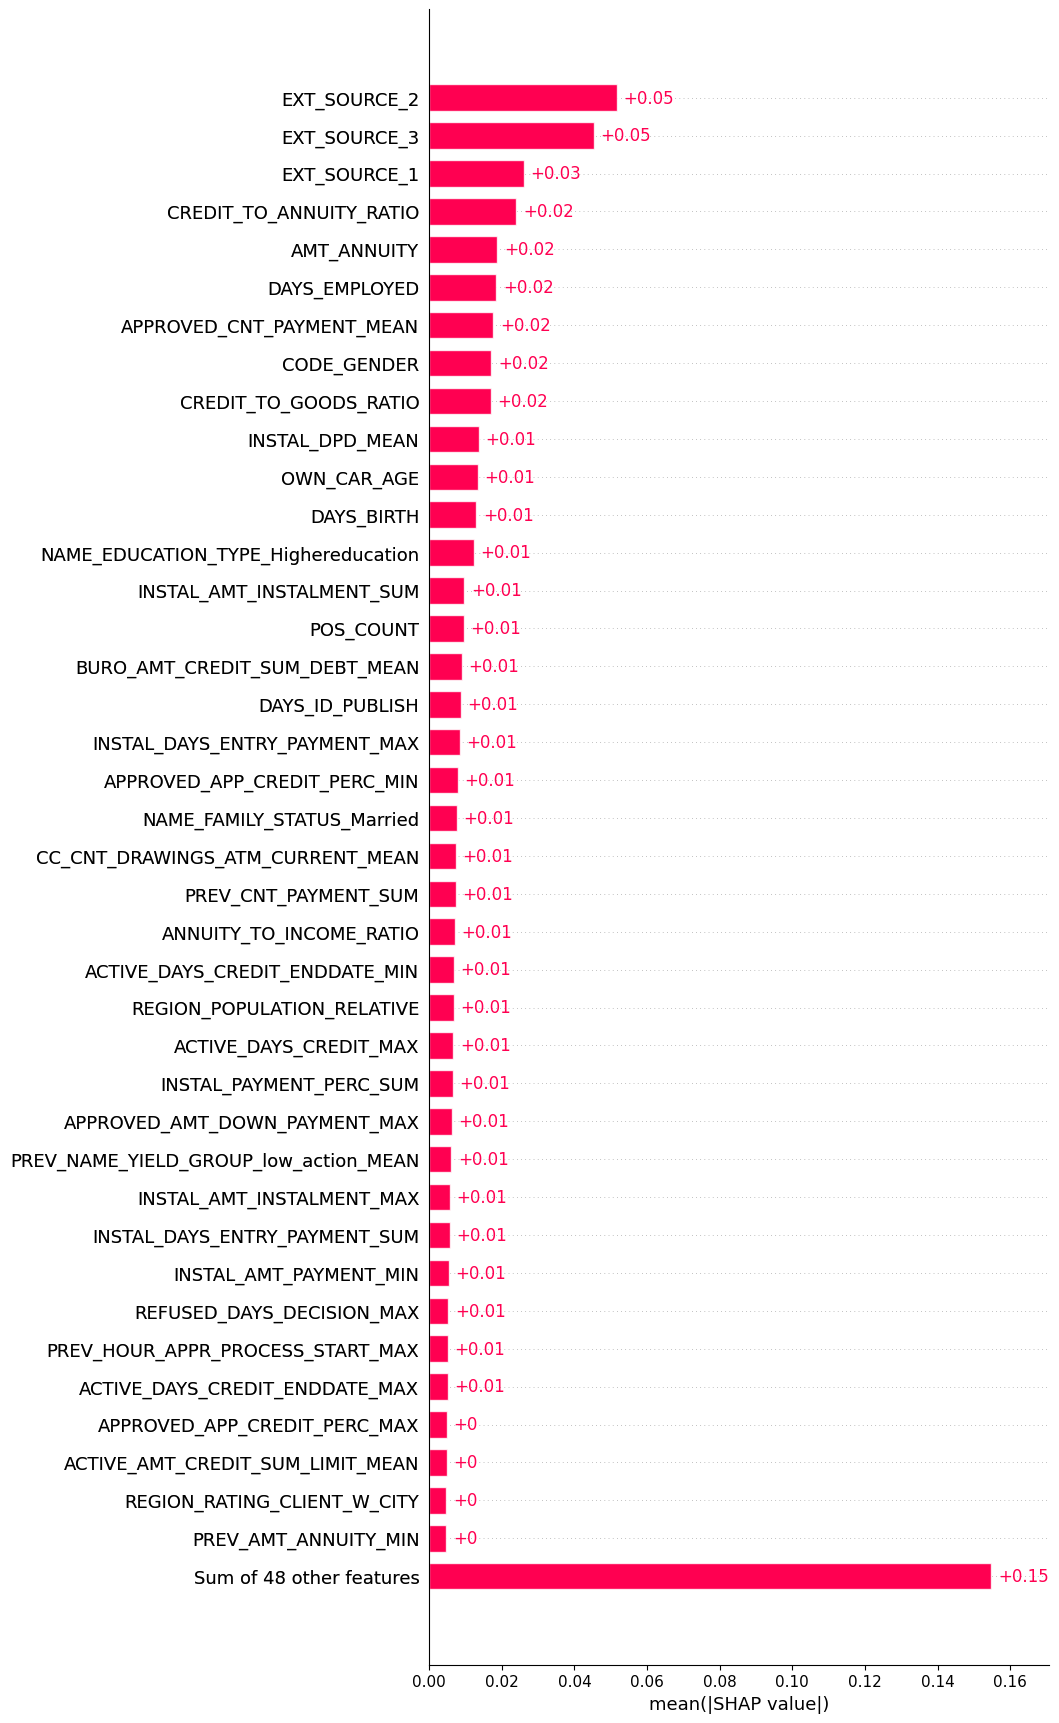

In [86]:
shap.plots.bar(shap_values.abs.mean(0), max_display=40)

### Beeswarm

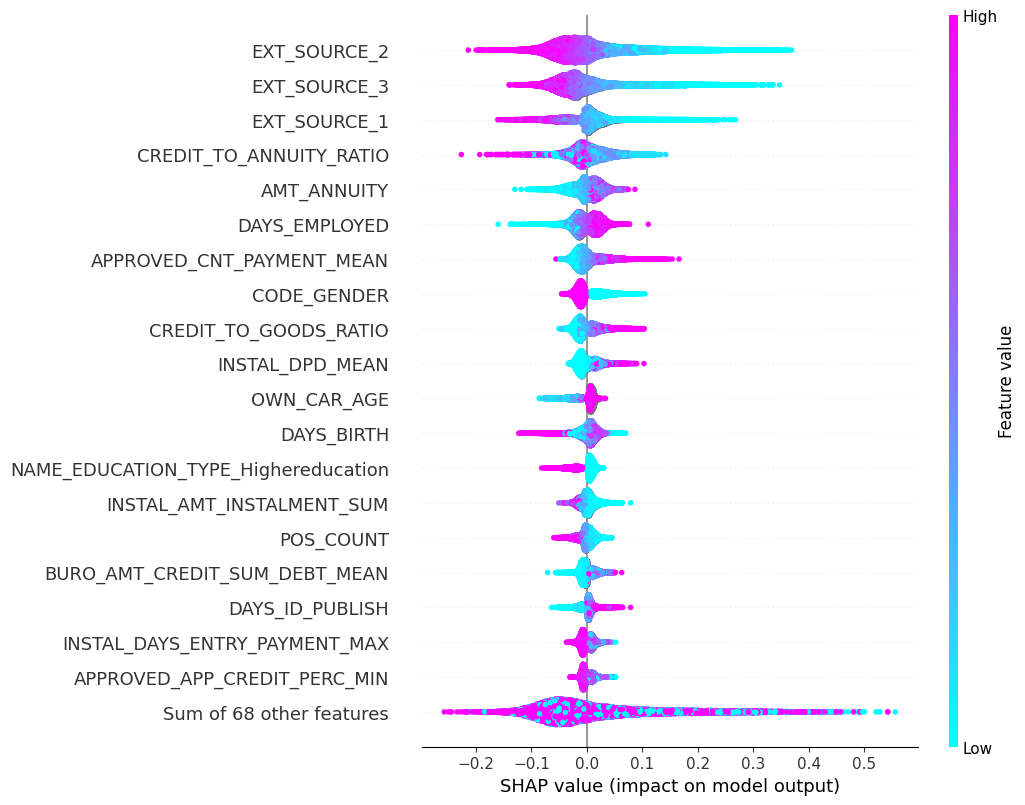

In [87]:
shap.plots.beeswarm(shap_values, max_display=20, color=plt.get_cmap("cool"))

## Local explanation : importance des features dans le risque de défaut d'un emprunteur particulier

In [88]:
pd.DataFrame(
    shap_values_loan.values, columns=X_new_loans.loc[[loan_idx], :].columns.to_list()
)

,CODE_GENDER,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_SUM,CC_AMT_BALANCE_MEAN,CC_AMT_PAYMENT_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_VAR
0,0.033512,-0.003575,0.008051,0.002438,0.021737,0.000925,0.003823,0.007819,0.001993,0.008756,...,0.001585,-0.01687,0.009288,-0.008101,-0.003534,0.019976,0.004962,0.027337,0.001553,-0.001672


### Waterfall

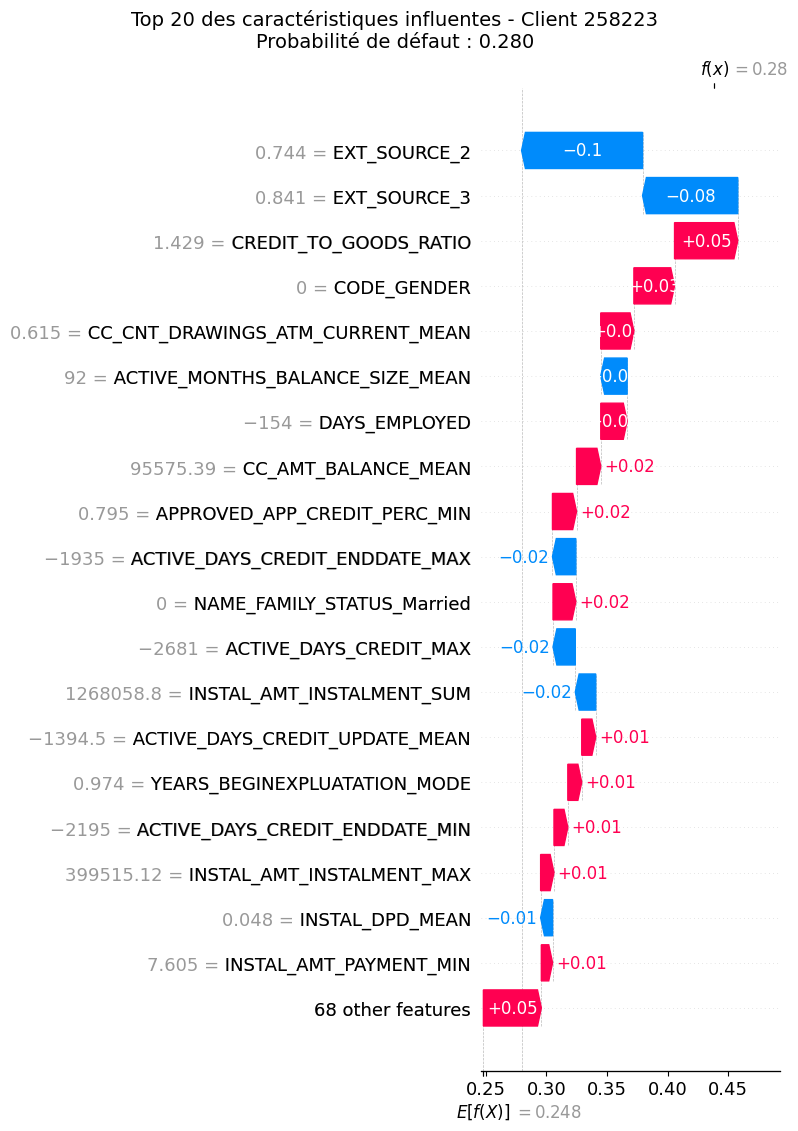

In [89]:
import matplotlib.patches as mpatches

# Index du client
loan_idx = 258223

# Récupération des données client
x_loan = X_new_loans.loc[[loan_idx], :]

# Explication SHAP locale
shap_values_loan = explainer(x_loan)

# Récupération de la prédiction (proba de défaut)
proba_defaut = model.predict_proba(x_loan)[0][1]

# Plot
fig = plt.figure(figsize=(10, 8))
shap.plots.waterfall(shap_values_loan[0], max_display=20, show=False)

plt.xlim([-0.5, 0.5])

plt.suptitle(
    f"Top 20 des caractéristiques influentes - Client {loan_idx}\n"
    f"Probabilité de défaut : {proba_defaut:.3f}",
    fontsize=14,
)
plt.tight_layout()
plt.show()

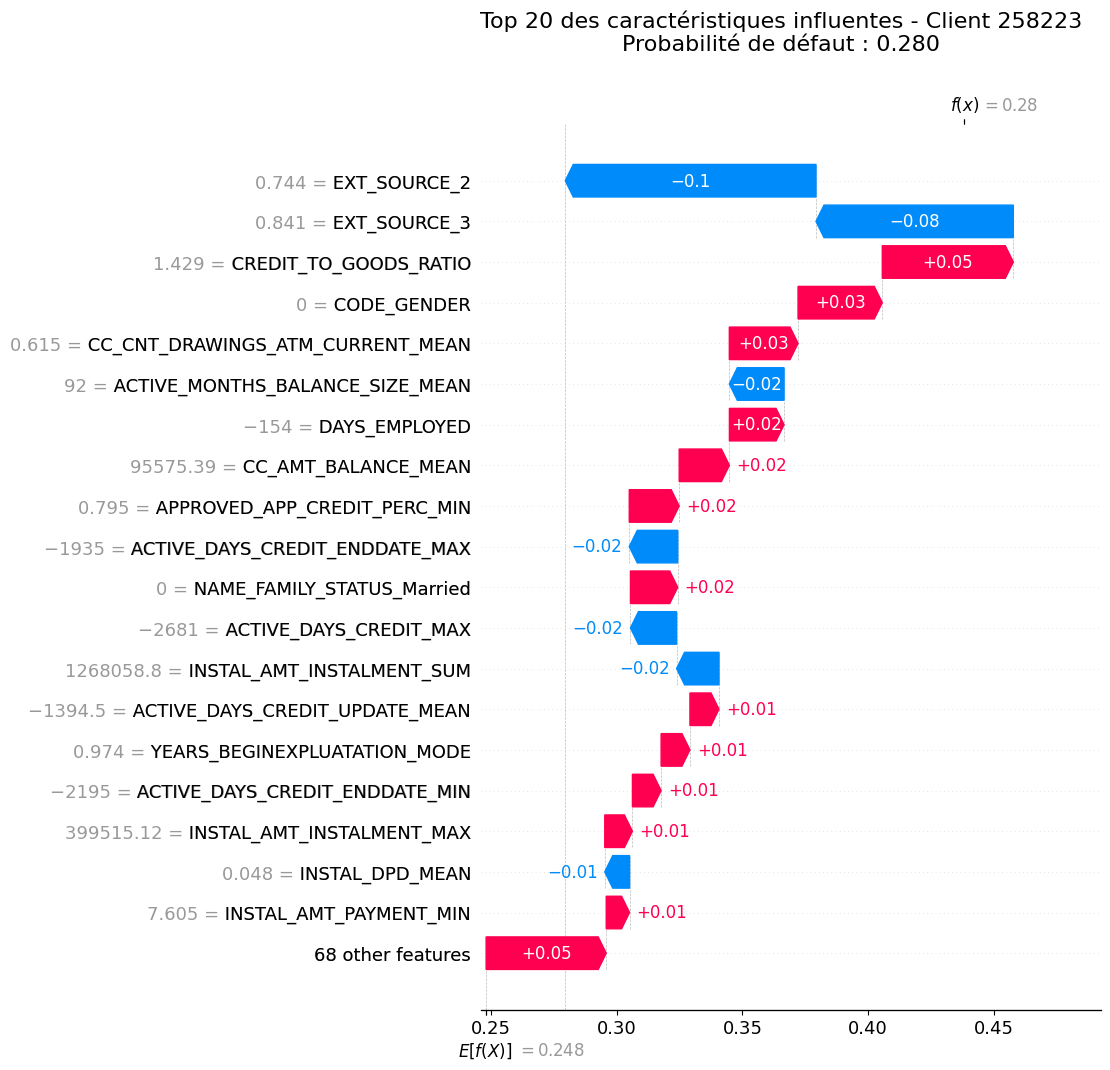

In [91]:
fig = plt.figure()

ax = plt.gca()
shap.waterfall_plot(shap_values_loan[0], max_display=20, show=False)

# Récupération de la prédiction (proba de défaut)
proba_defaut = model.predict_proba(x_loan)[0][1]

plt.suptitle(
    f"Top 20 des caractéristiques influentes - Client {loan_idx}\n"
    f"Probabilité de défaut : {proba_defaut:.3f}",
    fontsize=16,
)
# ax.set_xlabel()
"""ax.set_title("Contribution au risque de défaut",ha="left",
    x=0,
    y=-0.1,
    fontsize=ax.xaxis.label.get_fontsize(),)"""


"""# Ajout de la légende des couleurs

DEFAULT_COLOR_RISK = "#ca0020"
DEFAULT_COLOR_SAFE = "#92c5de"
red_patch = mpatches.Patch(color=DEFAULT_COLOR_RISK, label="⬆ Augmente le risque de défaut")
blue_patch = mpatches.Patch(color="#1E88E5", label="⬇ Diminue le risque de défaut")


plt.legend(handles=[red_patch, blue_patch])"""


plt.xlim([-0.5, 0.5])
plt.show()

In [92]:
fig.get_children()[0]

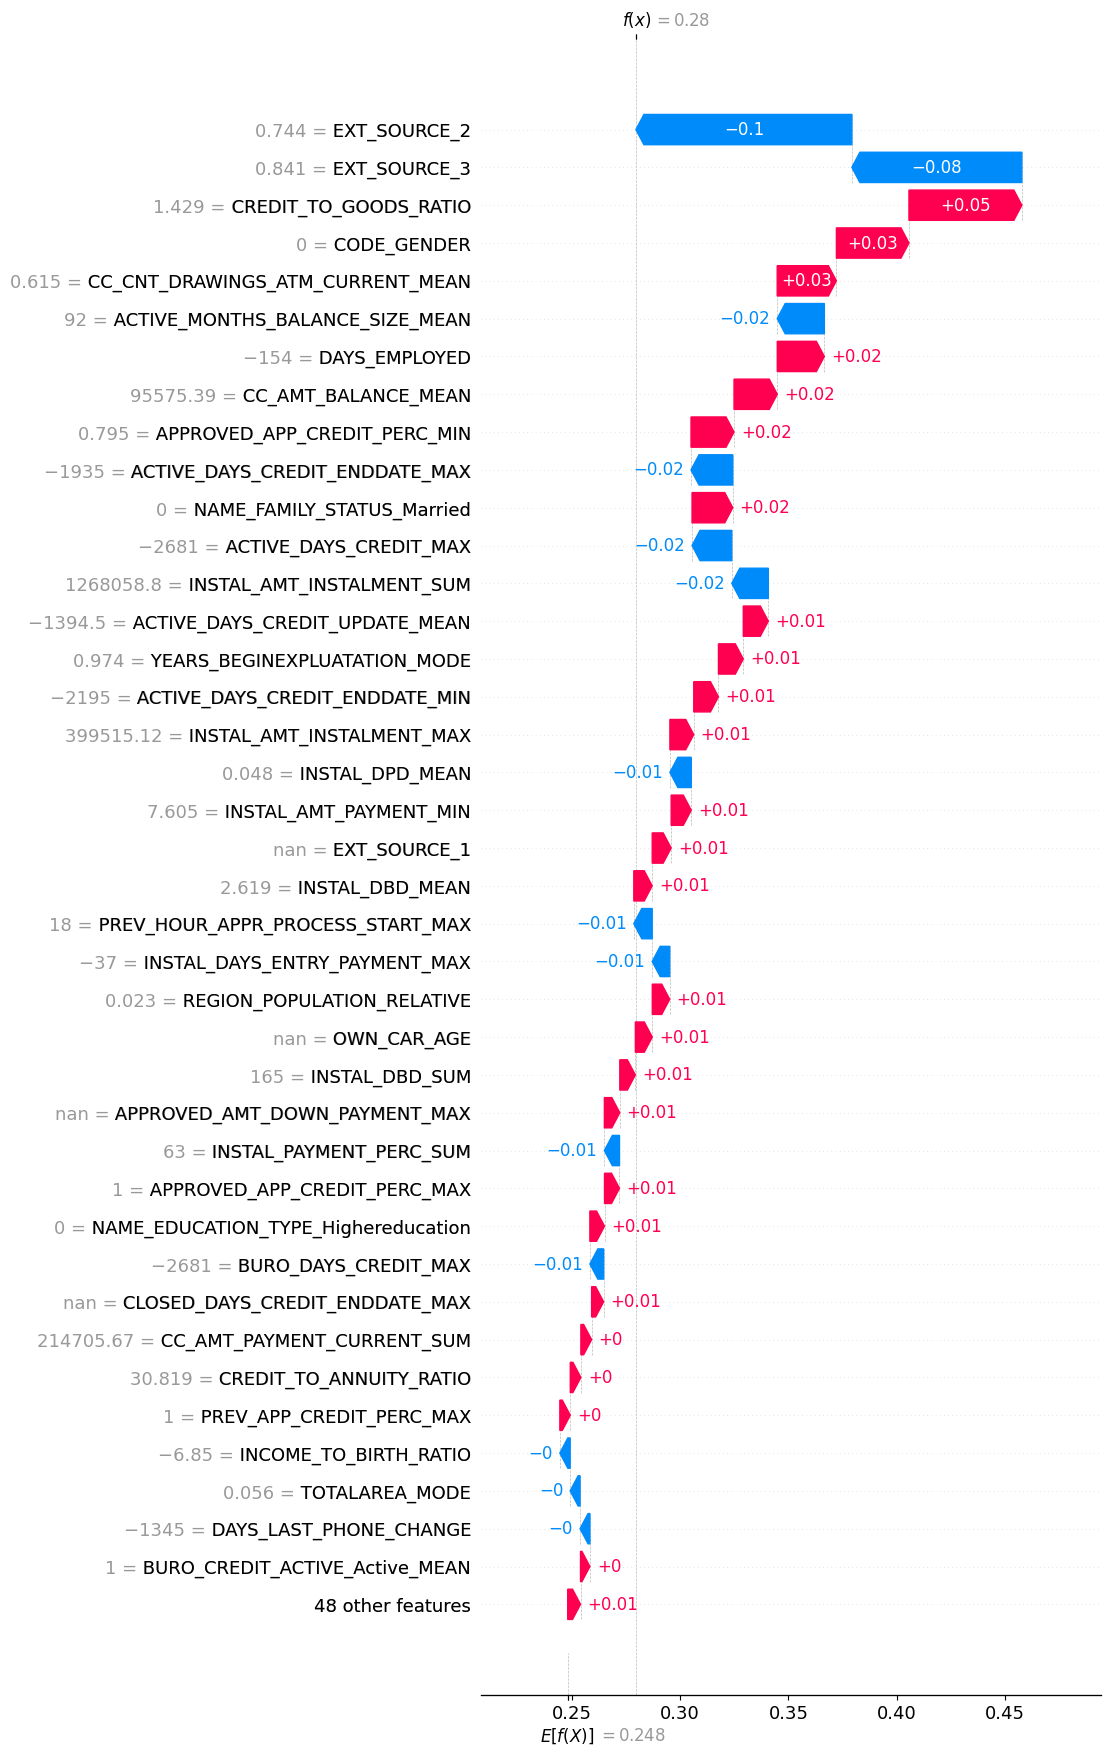

In [93]:
shap.waterfall_plot(shap_values_loan[0], max_display=40)

### Decision plot

## Ordre des features dans le train et dans le client

In [94]:
feature_names_loan = X_new_loans.loc[[loan_idx], :].columns.to_list()
feature_names_train = X_sampled_train.columns.to_list()
for i, name in enumerate(feature_names_loan):
    print("indice", i, "nom_loan", name, "nom_train", feature_names_train[i])
    if name != feature_names[i]:
        print("WARNING", i)

indice 0 nom_loan CODE_GENDER nom_train CODE_GENDER
indice 1 nom_loan AMT_ANNUITY nom_train AMT_ANNUITY
indice 2 nom_loan REGION_POPULATION_RELATIVE nom_train REGION_POPULATION_RELATIVE
indice 3 nom_loan DAYS_BIRTH nom_train DAYS_BIRTH
indice 4 nom_loan DAYS_EMPLOYED nom_train DAYS_EMPLOYED
indice 5 nom_loan DAYS_REGISTRATION nom_train DAYS_REGISTRATION
indice 6 nom_loan DAYS_ID_PUBLISH nom_train DAYS_ID_PUBLISH
indice 7 nom_loan OWN_CAR_AGE nom_train OWN_CAR_AGE
indice 8 nom_loan REGION_RATING_CLIENT_W_CITY nom_train REGION_RATING_CLIENT_W_CITY
indice 9 nom_loan EXT_SOURCE_1 nom_train EXT_SOURCE_1
indice 10 nom_loan EXT_SOURCE_2 nom_train EXT_SOURCE_2
indice 11 nom_loan EXT_SOURCE_3 nom_train EXT_SOURCE_3
indice 12 nom_loan YEARS_BEGINEXPLUATATION_MODE nom_train YEARS_BEGINEXPLUATATION_MODE
indice 13 nom_loan LIVINGAREA_MODE nom_train LIVINGAREA_MODE
indice 14 nom_loan TOTALAREA_MODE nom_train TOTALAREA_MODE
indice 15 nom_loan DEF_30_CNT_SOCIAL_CIRCLE nom_train DEF_30_CNT_SOCIAL_CIRCL

In [95]:
shap_values_loan

.values =
array([[ 3.35121419e-02, -3.57488799e-03,  8.05123390e-03,
         2.43791391e-03,  2.17370548e-02,  9.25034199e-04,
         3.82267046e-03,  7.81900138e-03,  1.99261969e-03,
         8.75561452e-03, -9.97324942e-02, -7.84965729e-02,
         1.14710125e-02, -1.77385516e-03, -4.57198930e-03,
        -1.08448252e-03, -4.55189492e-03,  4.89199802e-03,
         5.21276965e-02,  1.29610955e-03, -4.76169637e-03,
         6.76184051e-03,  1.88079570e-02, -6.35838706e-03,
        -1.54984730e-03, -9.62722670e-04, -4.54641414e-04,
         4.34133000e-03, -4.92024161e-05,  2.50746974e-03,
        -3.12287969e-03, -1.83580250e-02,  1.14123141e-02,
        -1.92761196e-02,  1.15565510e-02, -2.43882208e-03,
         9.02401744e-04, -2.58462554e-03,  3.76578214e-03,
        -2.17716698e-02,  8.75066023e-04,  2.02163280e-03,
         5.54994635e-03,  3.01466590e-03,  1.91972038e-03,
         4.31359712e-03, -1.21515033e-04, -4.26069783e-03,
         4.81986049e-03, -2.11406181e-03, -8.4

In [53]:
x_loan.columns.to_list()[10]

'EXT_SOURCE_2'

In [54]:
x_loan.columns.to_list()[11]

'EXT_SOURCE_3'

In [55]:
x_loan.columns.to_list()[18]

'CREDIT_TO_GOODS_RATIO'

In [56]:
shap_values_loan.values[0][:10]

array([ 0.03782563, -0.00079676,  0.00868089, -0.00064167,  0.0265626 ,
        0.00120961,  0.00500382,  0.01034873,  0.00235621,  0.00710135])

In [57]:
df_shap_values_loaner

CODE_GENDER                         0.037826
AMT_ANNUITY                        -0.000797
REGION_POPULATION_RELATIVE          0.008681
DAYS_BIRTH                         -0.000642
DAYS_EMPLOYED                       0.026563
                                      ...   
CC_AMT_BALANCE_MEAN                 0.016841
CC_AMT_PAYMENT_CURRENT_SUM          0.004749
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN    0.028851
CC_CNT_DRAWINGS_CURRENT_MEAN       -0.001759
CC_CNT_DRAWINGS_CURRENT_VAR        -0.006757
Length: 87, dtype: float64

In [58]:
df_shap_values_loaner.abs().sort_values(ascending=False)

EXT_SOURCE_2                        0.108567
EXT_SOURCE_3                        0.085416
CREDIT_TO_GOODS_RATIO               0.053999
CODE_GENDER                         0.037826
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN    0.028851
                                      ...   
CLOSED_AMT_CREDIT_SUM_SUM           0.000140
PREV_DAYS_DECISION_MAX              0.000126
BURO_CREDIT_TYPE_Microloan_MEAN     0.000058
INSTAL_AMT_INSTALMENT_MEAN          0.000033
BURO_CREDIT_TYPE_Mortgage_MEAN      0.000018
Length: 87, dtype: float64

In [59]:
sorted_features_loaner = (
    df_shap_values_loaner.abs().sort_values(ascending=False).index.to_list()
)
sorted_features_loaner

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'CREDIT_TO_GOODS_RATIO',
 'CODE_GENDER',
 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
 'DAYS_EMPLOYED',
 'ACTIVE_MONTHS_BALANCE_SIZE_MEAN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
 'NAME_FAMILY_STATUS_Married',
 'APPROVED_APP_CREDIT_PERC_MIN',
 'INSTAL_AMT_INSTALMENT_SUM',
 'ACTIVE_DAYS_CREDIT_MAX',
 'CC_AMT_BALANCE_MEAN',
 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
 'INSTAL_AMT_INSTALMENT_MAX',
 'INSTAL_DPD_MEAN',
 'YEARS_BEGINEXPLUATATION_MODE',
 'CREDIT_TO_ANNUITY_RATIO',
 'OWN_CAR_AGE',
 'PREV_HOUR_APPR_PROCESS_START_MAX',
 'INSTAL_AMT_PAYMENT_MIN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'REGION_POPULATION_RELATIVE',
 'INSTAL_DBD_MEAN',
 'APPROVED_CNT_PAYMENT_MEAN',
 'NAME_EDUCATION_TYPE_Highereducation',
 'APPROVED_APP_CREDIT_PERC_MAX',
 'APPROVED_AMT_DOWN_PAYMENT_MAX',
 'INSTAL_DBD_SUM',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'EXT_SOURCE_1',
 'CC_CNT_DRAWINGS_CURRENT_VAR',
 'BURO_DAYS_CREDIT_MAX',
 'INSTAL_PAYMENT_PERC_SUM',
 'INCOME_TO_BIRTH_RATIO',
 'DAYS_ID_PUBLISH',
 'C

['EXT_SOURCE_2' 'EXT_SOURCE_3' 'CREDIT_TO_GOODS_RATIO' 'CODE_GENDER'
 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN' 'DAYS_EMPLOYED'
 'ACTIVE_MONTHS_BALANCE_SIZE_MEAN' 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX'
 'NAME_FAMILY_STATUS_Married' 'APPROVED_APP_CREDIT_PERC_MIN'
 'INSTAL_AMT_INSTALMENT_SUM' 'ACTIVE_DAYS_CREDIT_MAX'
 'CC_AMT_BALANCE_MEAN' 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN'
 'INSTAL_AMT_INSTALMENT_MAX' 'INSTAL_DPD_MEAN'
 'YEARS_BEGINEXPLUATATION_MODE' 'CREDIT_TO_ANNUITY_RATIO' 'OWN_CAR_AGE'
 'PREV_HOUR_APPR_PROCESS_START_MAX' 'INSTAL_AMT_PAYMENT_MIN'
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN' 'REGION_POPULATION_RELATIVE'
 'INSTAL_DBD_MEAN' 'APPROVED_CNT_PAYMENT_MEAN'
 'NAME_EDUCATION_TYPE_Highereducation' 'APPROVED_APP_CREDIT_PERC_MAX'
 'APPROVED_AMT_DOWN_PAYMENT_MAX' 'INSTAL_DBD_SUM'
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX' 'EXT_SOURCE_1'
 'CC_CNT_DRAWINGS_CURRENT_VAR' 'BURO_DAYS_CREDIT_MAX'
 'INSTAL_PAYMENT_PERC_SUM' 'INCOME_TO_BIRTH_RATIO' 'DAYS_ID_PUBLISH'
 'CC_AMT_PAYMENT_CURRENT_SUM' 'CLOSED_DAYS_CREDIT_ENDDATE_M

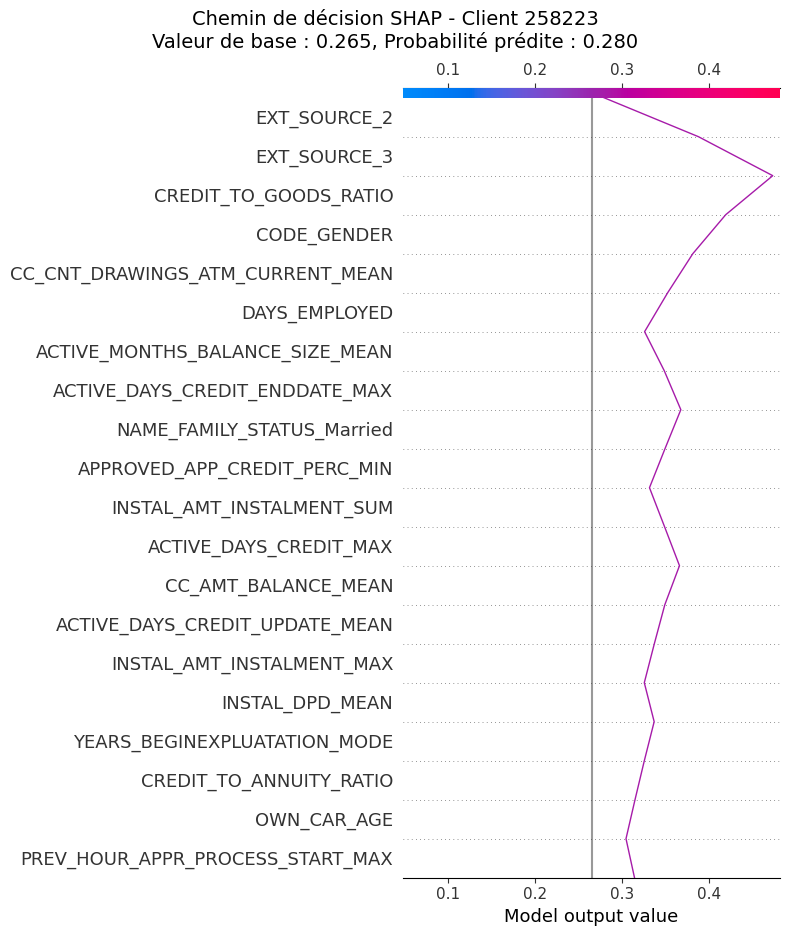

In [60]:
import shap
import matplotlib.pyplot as plt

loan_idx = 258223
x_loan = X_new_loans.loc[[loan_idx], :]

# SHAP values (un seul client)
shap_values_loan = explainer(x_loan)


# Tri
# Récupération des SHAP values et tri par importance absolue
shap_vals = shap_values_loan.values[0]
feature_names = x_loan.columns.to_numpy()
abs_order = np.argsort(-np.abs(shap_vals))  # ordre décroissant

# Réduction à n features
n = 87
top_idx = abs_order[:n]
top_shap_vals = shap_vals[top_idx]
top_names = feature_names[top_idx]
print(top_names)

feature_names = x_loan.columns.to_list()
fig = plt.figure()

ax = plt.gca()


# Récupération de la prédiction (proba de défaut)
proba_defaut = model.predict_proba(x_loan)[0][1]
# Decision plot
shap_values_loan.values[0]
# shap.decision_plot(base_value=explainer.expected_value, shap_values=shap_values_loan.values[0], feature_names=x_loan.columns.to_list(), feature_order=None)
# shap.decision_plot(base_value=explainer.expected_value, shap_values=shap_values_loan.values[0], feature_order=None)
shap.plots.decision(
    shap_values=explainer.shap_values(x_loan),
    base_value=explainer.expected_value,
    # feature_names=sorted_features_loaner,
    feature_names=feature_names,
    feature_order="importance",
    show=False,
)
# shap.plots.decision(shap_values=explainer.shap_values(x_loan), base_value=explainer.expected_value, feature_names=top_names)
# shap.plots.decision(shap_values=explainer.shap_values(x_loan), base_value=explainer.expected_value)

# Optionnel : titre
fig.suptitle(
    f"Chemin de décision SHAP - Client {loan_idx}\n"
    f"Valeur de base : {explainer.expected_value:.3f}, Probabilité prédite : {model.predict_proba(x_loan)[:, 1][0]:.3f}",
    fontsize=14,
)
plt.tight_layout()
plt.show()

In [61]:
df_shap_values_loaner[
    ["EXT_SOURCE_2", "EXT_SOURCE_3", "CREDIT_TO_GOODS_RATIO", "CODE_GENDER"]
]

EXT_SOURCE_2            -0.108567
EXT_SOURCE_3            -0.085416
CREDIT_TO_GOODS_RATIO    0.053999
CODE_GENDER              0.037826
dtype: float64